In [0]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
metadata = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/movie_metadata.csv')
metadata.head(10)

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0
5,Color,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,Action|Adventure|Sci-Fi,...,738.0,English,USA,PG-13,263700000.0,2012.0,632.0,6.6,2.35,24000
6,Color,Sam Raimi,392.0,156.0,0.0,4000.0,James Franco,24000.0,336530303.0,Action|Adventure|Romance,...,1902.0,English,USA,PG-13,258000000.0,2007.0,11000.0,6.2,2.35,0
7,Color,Nathan Greno,324.0,100.0,15.0,284.0,Donna Murphy,799.0,200807262.0,Adventure|Animation|Comedy|Family|Fantasy|Musi...,...,387.0,English,USA,PG,260000000.0,2010.0,553.0,7.8,1.85,29000
8,Color,Joss Whedon,635.0,141.0,0.0,19000.0,Robert Downey Jr.,26000.0,458991599.0,Action|Adventure|Sci-Fi,...,1117.0,English,USA,PG-13,250000000.0,2015.0,21000.0,7.5,2.35,118000
9,Color,David Yates,375.0,153.0,282.0,10000.0,Daniel Radcliffe,25000.0,301956980.0,Adventure|Family|Fantasy|Mystery,...,973.0,English,UK,PG,250000000.0,2009.0,11000.0,7.5,2.35,10000


In [0]:
metadata.shape

(5043, 28)

In [0]:
metadata.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes'],
      dtype='object')

In [0]:
metadata = metadata[~metadata['genres'].str.contains("Documentary")]
metadata.shape

(4922, 28)

In [0]:
columns = ['num_critic_for_reviews', 'num_user_for_reviews', 'num_voted_users', 'color', 'content_rating', 'director_facebook_likes', 'actor_3_facebook_likes', 'actor_1_facebook_likes', 'cast_total_facebook_likes', 'facenumber_in_poster', 'actor_2_facebook_likes', 'movie_facebook_likes', 'aspect_ratio']
metadata = metadata.drop(columns, 1)
metadata.shape

(4922, 15)

In [0]:
metadata.columns

Index(['director_name', 'duration', 'actor_2_name', 'gross', 'genres',
       'actor_1_name', 'movie_title', 'actor_3_name', 'plot_keywords',
       'movie_imdb_link', 'language', 'country', 'budget', 'title_year',
       'imdb_score'],
      dtype='object')

In [0]:
metadata['title_year'].unique()

array([2009., 2007., 2015., 2012., 2010., 2016., 2006., 2008., 2013.,
       2011., 2014., 2005., 1997., 2004., 1999., 1995., 2003., 2001.,
       2002., 1998.,   nan, 2000., 1990., 1991., 1994., 1996., 1982.,
       1993., 1979., 1992., 1989., 1984., 1988., 1978., 1962., 1980.,
       1972., 1981., 1968., 1985., 1940., 1963., 1987., 1986., 1973.,
       1983., 1976., 1977., 1970., 1971., 1969., 1960., 1965., 1964.,
       1927., 1974., 1937., 1975., 1967., 1951., 1961., 1946., 1953.,
       1954., 1959., 1932., 1947., 1956., 1945., 1952., 1930., 1966.,
       1939., 1950., 1948., 1958., 1957., 1943., 1944., 1938., 1949.,
       1936., 1941., 1955., 1942., 1929., 1935., 1933., 1916., 1934.,
       1925., 1920.])

In [0]:
metadata = metadata.drop(metadata[metadata['title_year'].astype(str)=='nan'].index)
metadata.shape

(4816, 15)

In [0]:
metadata = metadata[metadata['title_year'].astype(int) >= 1968]

In [0]:
metadata.shape

(4690, 15)

In [0]:
highscore = metadata[metadata['imdb_score'].astype(float) >= 6.5]
highscore.shape
boxofficehit = highscore[highscore['gross'].astype(float) > 30000000.0]
boxofficehit.shape
successful = boxofficehit[boxofficehit['gross'].astype(float) > boxofficehit['budget'].astype(float)]
successful.shape

(895, 15)

In [0]:
lowscore = metadata[metadata['imdb_score'].astype(float) < 6.5]
lowscore.shape
unsuccessful = lowscore[lowscore['gross'].astype(float) <= lowscore['budget'].astype(float)]
unsuccessful.shape

(980, 15)

In [0]:
successful.head()

,director_name,duration,actor_2_name,gross,genres,actor_1_name,movie_title,actor_3_name,plot_keywords,movie_imdb_link,language,country,budget,title_year,imdb_score
0,James Cameron,178.0,Joel David Moore,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,Wes Studi,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,English,USA,237000000.0,2009.0,7.9
1,Gore Verbinski,169.0,Orlando Bloom,309404152.0,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,Jack Davenport,goddess|marriage ceremony|marriage proposal|pi...,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,English,USA,300000000.0,2007.0,7.1
3,Christopher Nolan,164.0,Christian Bale,448130642.0,Action|Thriller,Tom Hardy,The Dark Knight Rises,Joseph Gordon-Levitt,deception|imprisonment|lawlessness|police offi...,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,English,USA,250000000.0,2012.0,8.5
8,Joss Whedon,141.0,Robert Downey Jr.,458991599.0,Action|Adventure|Sci-Fi,Chris Hemsworth,Avengers: Age of Ultron,Scarlett Johansson,artificial intelligence|based on comic book|ca...,http://www.imdb.com/title/tt2395427/?ref_=fn_t...,English,USA,250000000.0,2015.0,7.5
9,David Yates,153.0,Daniel Radcliffe,301956980.0,Adventure|Family|Fantasy|Mystery,Alan Rickman,Harry Potter and the Half-Blood Prince,Rupert Grint,blood|book|love|potion|professor,http://www.imdb.com/title/tt0417741/?ref_=fn_t...,English,UK,250000000.0,2009.0,7.5


In [0]:
unsuccessful.head()

,director_name,duration,actor_2_name,gross,genres,actor_1_name,movie_title,actor_3_name,plot_keywords,movie_imdb_link,language,country,budget,title_year,imdb_score
11,Bryan Singer,169.0,Marlon Brando,200069408.0,Action|Adventure|Sci-Fi,Kevin Spacey,Superman Returns,Frank Langella,crystal|epic|lex luthor|lois lane|return to earth,http://www.imdb.com/title/tt0348150/?ref_=fn_t...,English,USA,209000000.0,2006.0,6.1
24,Chris Weitz,113.0,Eva Green,70083519.0,Adventure|Family|Fantasy,Christopher Lee,The Golden Compass,Kristin Scott Thomas,children|epic|friend|girl|quest,http://www.imdb.com/title/tt0385752/?ref_=fn_t...,English,USA,180000000.0,2007.0,6.1
28,Peter Berg,131.0,Alexander Skarsgård,65173160.0,Action|Adventure|Sci-Fi|Thriller,Liam Neeson,Battleship,Tadanobu Asano,box office flop|hawaii|naval|oahu hawaii|ship,http://www.imdb.com/title/tt1440129/?ref_=fn_t...,English,USA,209000000.0,2012.0,5.9
41,John Lasseter,106.0,Thomas Kretschmann,191450875.0,Adventure|Animation|Comedy|Family|Sport,Joe Mantegna,Cars 2,Eddie Izzard,best friend|car race|conspiracy|gadget car|spy,http://www.imdb.com/title/tt1216475/?ref_=fn_t...,English,USA,200000000.0,2011.0,6.3
42,Martin Campbell,123.0,Temuera Morrison,116593191.0,Action|Adventure|Sci-Fi,Ryan Reynolds,Green Lantern,Taika Waititi,autopsy|lantern|planet|ring|test pilot,http://www.imdb.com/title/tt1133985/?ref_=fn_t...,English,USA,200000000.0,2011.0,5.6


In [0]:
successful = successful.join(successful.pop('genres').str.get_dummies('|'))
successful.head()

,director_name,duration,actor_2_name,gross,actor_1_name,movie_title,actor_3_name,plot_keywords,movie_imdb_link,language,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,James Cameron,178.0,Joel David Moore,760505847.0,CCH Pounder,Avatar,Wes Studi,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,English,...,0,0,0,0,0,1,0,0,0,0
1,Gore Verbinski,169.0,Orlando Bloom,309404152.0,Johnny Depp,Pirates of the Caribbean: At World's End,Jack Davenport,goddess|marriage ceremony|marriage proposal|pi...,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,English,...,0,0,0,0,0,0,0,0,0,0
3,Christopher Nolan,164.0,Christian Bale,448130642.0,Tom Hardy,The Dark Knight Rises,Joseph Gordon-Levitt,deception|imprisonment|lawlessness|police offi...,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,English,...,0,0,0,0,0,0,0,1,0,0
8,Joss Whedon,141.0,Robert Downey Jr.,458991599.0,Chris Hemsworth,Avengers: Age of Ultron,Scarlett Johansson,artificial intelligence|based on comic book|ca...,http://www.imdb.com/title/tt2395427/?ref_=fn_t...,English,...,0,0,0,0,0,1,0,0,0,0
9,David Yates,153.0,Daniel Radcliffe,301956980.0,Alan Rickman,Harry Potter and the Half-Blood Prince,Rupert Grint,blood|book|love|potion|professor,http://www.imdb.com/title/tt0417741/?ref_=fn_t...,English,...,0,0,0,1,0,0,0,0,0,0


In [0]:
unsuccessful = unsuccessful.join(unsuccessful.pop('genres').str.get_dummies('|'))
unsuccessful.head()

,director_name,duration,actor_2_name,gross,actor_1_name,movie_title,actor_3_name,plot_keywords,movie_imdb_link,language,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
11,Bryan Singer,169.0,Marlon Brando,200069408.0,Kevin Spacey,Superman Returns,Frank Langella,crystal|epic|lex luthor|lois lane|return to earth,http://www.imdb.com/title/tt0348150/?ref_=fn_t...,English,...,0,0,0,0,0,1,0,0,0,0
24,Chris Weitz,113.0,Eva Green,70083519.0,Christopher Lee,The Golden Compass,Kristin Scott Thomas,children|epic|friend|girl|quest,http://www.imdb.com/title/tt0385752/?ref_=fn_t...,English,...,0,0,0,0,0,0,0,0,0,0
28,Peter Berg,131.0,Alexander Skarsgård,65173160.0,Liam Neeson,Battleship,Tadanobu Asano,box office flop|hawaii|naval|oahu hawaii|ship,http://www.imdb.com/title/tt1440129/?ref_=fn_t...,English,...,0,0,0,0,0,1,0,1,0,0
41,John Lasseter,106.0,Thomas Kretschmann,191450875.0,Joe Mantegna,Cars 2,Eddie Izzard,best friend|car race|conspiracy|gadget car|spy,http://www.imdb.com/title/tt1216475/?ref_=fn_t...,English,...,0,0,0,0,0,0,1,0,0,0
42,Martin Campbell,123.0,Temuera Morrison,116593191.0,Ryan Reynolds,Green Lantern,Taika Waititi,autopsy|lantern|planet|ring|test pilot,http://www.imdb.com/title/tt1133985/?ref_=fn_t...,English,...,0,0,0,0,0,1,0,0,0,0


In [0]:
successful.columns

Index(['director_name', 'duration', 'actor_2_name', 'gross', 'actor_1_name',
       'movie_title', 'actor_3_name', 'plot_keywords', 'movie_imdb_link',
       'language', 'country', 'budget', 'title_year', 'imdb_score', 'Action',
       'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Drama',
       'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical', 'Mystery',
       'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western'],
      dtype='object')

In [0]:
ncol = len(successful.columns)
s_genres = successful[successful.columns[14:ncol]]
s_genres.columns

Index(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical',
       'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western'],
      dtype='object')

In [0]:
ncol = len(unsuccessful.columns)
u_genres = unsuccessful[unsuccessful.columns[14:ncol]]
u_genres.columns

Index(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical',
       'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western'],
      dtype='object')

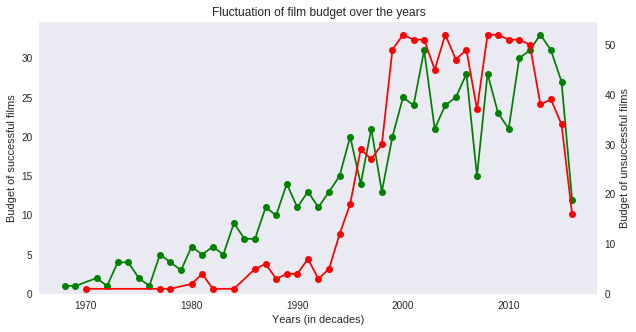

In [0]:
import matplotlib.pyplot as plt
bdgt_analysis_s = successful[['budget', 'title_year']].groupby('title_year')
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(bdgt_analysis_s.title_year.first(), bdgt_analysis_s.budget.nunique(), "g-o")
ax1.grid(None)
ax1.set_ylim(0,)

# green - successful, red - unsuccessful

bdgt_analysis_u = unsuccessful[['budget', 'title_year']].groupby('title_year')
ax2 = ax1.twinx()
ax2.plot(bdgt_analysis_u.title_year.first(), bdgt_analysis_u.budget.count(), "r-o")
ax2.grid(None)
ax2.set_ylim(0,)

ax1.set_xlabel('Years (in decades)')
ax1.set_ylabel('Budget of successful films'); ax2.set_ylabel('Budget of unsuccessful films')
plt.title('Fluctuation of film budget over the years')
plt.show()

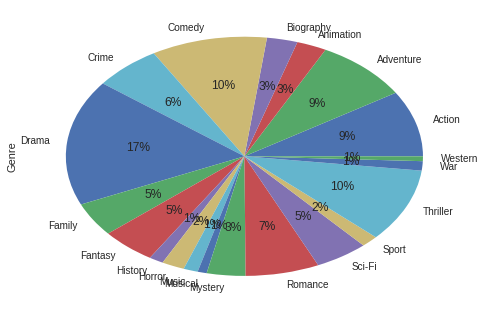

In [0]:
s_genres.sum().plot.pie(label='Genre', autopct='%1.0f%%')

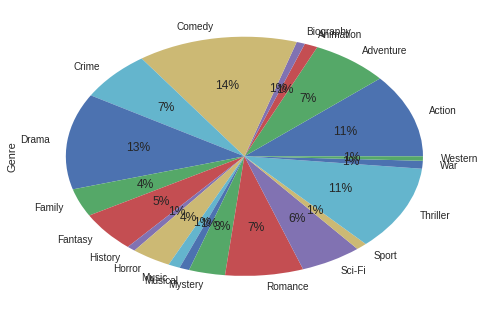

In [0]:
u_genres.sum().plot.pie(label='Genre', autopct='%1.0f%%')

In [0]:
s_duration = successful.groupby('duration').agg([np.mean, np.median, sum])
s_duration.tail()

gross                                 budget               \
                 mean       median          sum         mean       median   
duration                                                                    
219.0      43984230.0   43984230.0   43984230.0   23000000.0   23000000.0   
220.0      57300000.0   57300000.0   57300000.0   13000000.0   13000000.0   
236.0     184208848.0  184208848.0  184208848.0   22000000.0   22000000.0   
240.0     116866727.0  116866727.0  116866727.0  100000000.0  100000000.0   
289.0      78800000.0   78800000.0   78800000.0   31500000.0   31500000.0   

                      title_year                 imdb_score ... Sport  \
                  sum       mean  median     sum       mean ...   sum   
duration                                                    ...         
219.0      23000000.0     1987.0  1987.0  1987.0        7.8 ...     0   
220.0      13000000.0     1974.0  1974.0  1974.0        9.0 ...     0   
236.0      22000000.0     1990.0  1990.0  1990.0        8.0 ...     0   
240.0     100000000.0     2013.0  2013.0  2013.0        8.2 ...     0   
289.0      31500000.0     1979.0  1979.0  1979.0        8.5 ...     0   

         Thriller             War            Western             
             mean median sum mean median sum    mean median sum  
duration                                                         
219.0         0.0    0.0   0  0.0    0.0   0     0.0    0.0   0  
220.0         0.0    0.0   0  0.0    0.0   0     0.0    0.0   0  
236.0         0.0    0.0   0  0.0    0.0   0     1.0    1.0   1  
240.0         0.0    0.0   0  0.0    0.0   0     0.0    0.0   0  
289.0         0.0    0.0   0  1.0    1.0   1     0.0    0.0   0  

[5 rows x 72 columns]

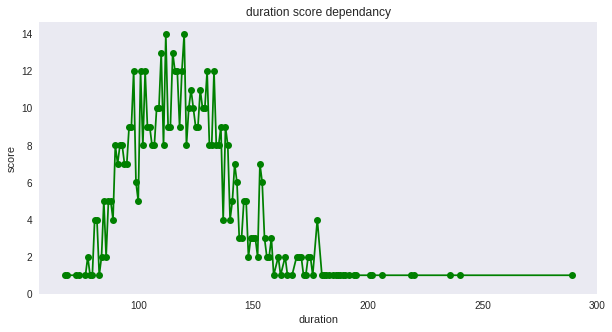

In [0]:
rat_dur = successful[['imdb_score', 'duration']].groupby('duration')
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(rat_dur.duration.first(), rat_dur.imdb_score.nunique(), "g-o")
ax1.grid(None)
ax1.set_ylim(0,)
ax1.set_xlabel('duration')
ax1.set_ylabel('score')
plt.title('duration score dependancy')
plt.show()

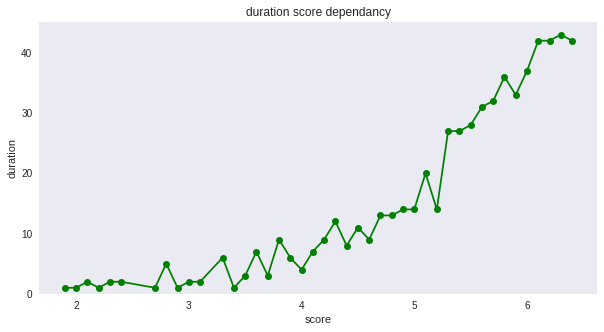

In [0]:
rat_dur = unsuccessful[['duration', 'imdb_score']].groupby('imdb_score')
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(rat_dur.imdb_score.first(), rat_dur.duration.nunique(), "g-o")
ax1.grid(None)
ax1.set_ylim(0,)
ax1.set_xlabel('score')
ax1.set_ylabel('duration')
plt.title('duration score dependancy')
plt.show()